In [1]:
!pip install rdkit
!pip install pubchempy
!pip install torch
!pip install torch_geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 47.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13818 sha256=d1fce33401064dba84b3ff820e2960300de7cedeb6dbe91faebaa8871e76d60a
  Stored in directory: /root/.cache/pip/wheels/78/0f/d0/080f82ce0d7fdc771401b6acac304bd2ee77d67dee34737bd6
Successfully built pubchempy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.0 MB/s eta 0:00:00


In [2]:
from pandas.plotting import table
from rdkit.Chem import Draw
from rdkit import Chem
from sklearn.metrics import r2_score
from torch_geometric.data import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.utils import to_networkx
from torch.nn import Linear

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import pubchempy
import rdkit
import time
import torch
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")

In [3]:
dataset = MoleculeNet(root=".", name="lipo")
data = dataset[0]

Processing...
Done!


In [4]:
print('\n======== Dataset =======\n')
print("Dataset type: ", type(dataset))
print("Dataset size (graphs): ", len(dataset))
print("Dataset features: ", dataset.num_features)
print("Dataset target: ", dataset.num_classes)
print("Dataset length: ", dataset.len)
print('\n======== first sample =======\n')
print("Dataset sample: ", data)
print("Sample  nodes: ", data.num_nodes)
print("Sample  edges: ", data.num_edges)


======== Dataset =======

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset size (graphs):  4200
Dataset features:  9
Dataset target:  553
Dataset length:  <bound method InMemoryDataset.len of Lipophilicity(4200)>

======== first sample =======

Dataset sample:  Data(x=[24, 9], edge_index=[2, 54], edge_attr=[54, 3], smiles='Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14', y=[1, 1])
Sample  nodes:  24
Sample  edges:  54


In [5]:
dataset[0].x[:5]

tensor([[6, 0, 4, 5, 3, 0, 4, 0, 0],
        [7, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [7, 0, 3, 5, 0, 0, 4, 0, 1]])

In [6]:
dataset[0].edge_index.t()[:5]


tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 1, 23],
        [ 2,  1]])

In [7]:
dataset[0].y


tensor([[3.5400]])

In [8]:
sm = dataset[0]['smiles']
compound = pubchempy.get_compounds(sm, namespace='smiles')
match = compound[0]
match.iupac_name


'2-[[4-(4-chlorophenyl)piperazin-1-yl]methyl]-1-methylbenzimidazole'

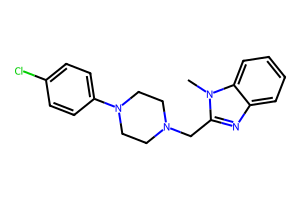

In [9]:
molecule = Draw.MolsToGridImage([Chem.MolFromSmiles(sm)],
                molsPerRow=1, subImgSize=(300,200), returnPNG=False)
molecule

In [10]:
top_n = 12
data_attrib = []

for data in dataset[:top_n]:
    data_attrib.append([data.num_nodes, data.num_edges, data.smiles, np.array(data.y[0])[0]])

data_attr = pd.DataFrame(data_attrib)
data_attr.columns = ['num_nodes', 'num_edges', 'smiles', 'target_logD']
data_attr.head(top_n)

,num_nodes,num_edges,smiles,target_logD
0,24,54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,3.54
1,33,70,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,-1.18
2,21,46,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,3.69
3,28,62,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,3.37
4,28,58,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,3.10
5,23,52,OC1(CN2CCC1CC2)C#Cc3ccc(cc3)c4ccccc4,3.14
6,35,74,COc1cc(OC)c(cc1NC(=O)CCC(=O)O)S(=O)(=O)NCc2ccc...,-0.72
7,34,72,CNc1cccc(CCOc2ccc(C[C@H](NC(=O)c3c(Cl)cccc3Cl)...,0.34
8,23,50,COc1ccc(cc1)C2=COc3cc(OC)cc(OC)c3C2=O,3.05
9,15,34,Oc1ncnc2scc(c3ccsc3)c12,2.25


In [11]:
ch_names = []
for i in data_attr["smiles"]:
    compounds = pubchempy.get_compounds(i, namespace='smiles')
    match = compounds[0]
    names = [match.iupac_name.split(')')[-1], match.iupac_name.split(']')[-1]]
    res = min(names, key=len)
    ch_names.append(res)
chem_names = ['... ' + str(i) for i in ch_names]
data_attr["name"] = chem_names
data_attr


,num_nodes,num_edges,smiles,target_logD,name
0,24,54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,3.54,... -1-methylbenzimidazole
1,33,70,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,-1.18,... sulfanylacetic acid
2,21,46,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,3.69,... acetate
3,28,62,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,3.37,... pyrrole-5-carboxamide
4,28,58,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,3.10,... -2-methylpyrazole-3-carboxamide
5,23,52,OC1(CN2CCC1CC2)C#Cc3ccc(cc3)c4ccccc4,3.14,... octan-3-ol
6,35,74,COc1cc(OC)c(cc1NC(=O)CCC(=O)O)S(=O)(=O)NCc2ccc...,-0.72,... -4-oxobutanoic acid
7,34,72,CNc1cccc(CCOc2ccc(C[C@H](NC(=O)c3c(Cl)cccc3Cl)...,0.34,... propanoic acid
8,23,50,COc1ccc(cc1)C2=COc3cc(OC)cc(OC)c3C2=O,3.05,... chromen-4-one
9,15,34,Oc1ncnc2scc(c3ccsc3)c12,2.25,... pyrimidin-4-one


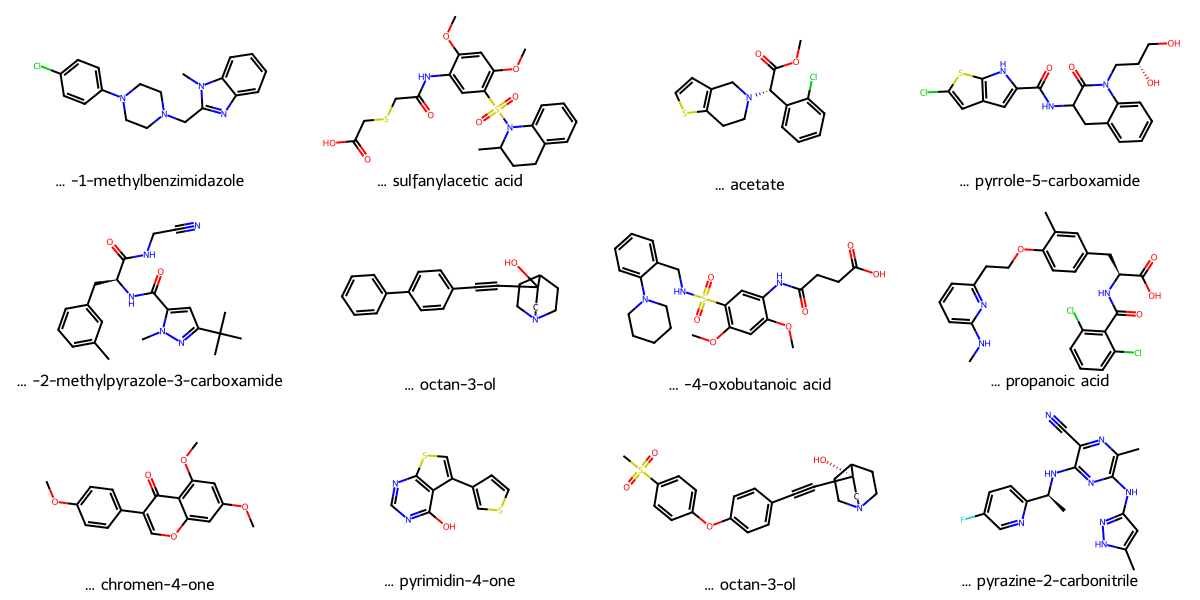

In [12]:
img = Draw.MolsToGridImage([Chem.MolFromSmiles(data_attr["smiles"][i]) for i in range(top_n)],
                         molsPerRow=4,subImgSize=(300,200), legends=list(data_attr.name.values),
                         returnPNG=False)
img

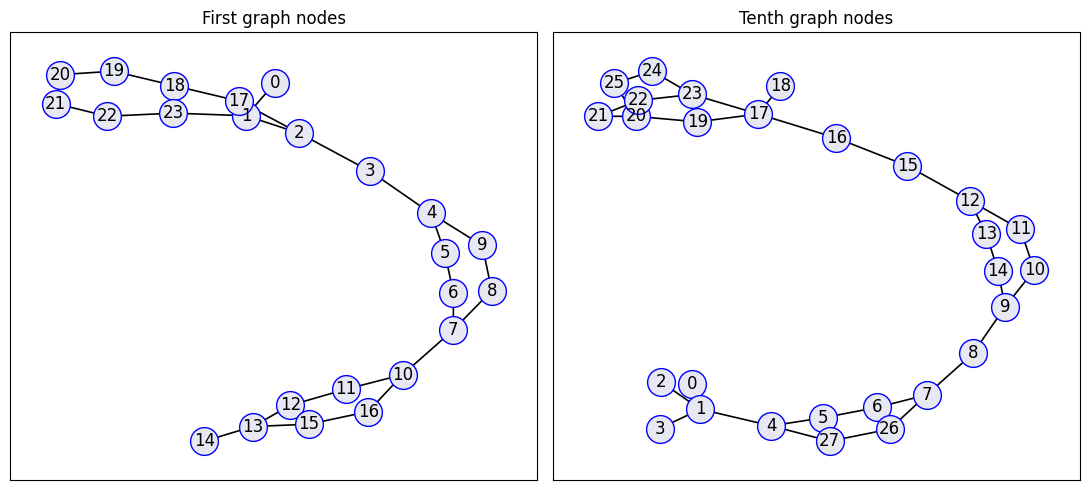

In [13]:
import matplotlib.pyplot as plt

def visualize_net():
    plt.figure(figsize=(11,5))
    ax1 = plt.subplot2grid(shape=(1, 2), loc=(0,0))
    ax2 = plt.subplot2grid(shape=(1, 2), loc=(0,1))
    ax1.set_title('First graph nodes')
    ax2.set_title('Tenth graph nodes')

    G = to_networkx(dataset[0], to_undirected=True)

    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=14), with_labels=True,
                     node_color=[0.91, 0.91, 0.95], node_size=400, width=1.2,
                     edgecolors='blue', cmap="Set2", ax=ax1)

    G = to_networkx(dataset[10], to_undirected=True)
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=14), with_labels=True,
                    node_color=[0.91, 0.91, 0.95], node_size=400, width=1.2,
                    edgecolors='blue', cmap="Set2", ax=ax2)
    plt.tight_layout()
    plt.show()

visualize_net()

In [14]:
embedding_size = 64
class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size*2, 1)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)

        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index),
                            gap(hidden, batch_index)], dim=1)

        # Classifier (Linear).
        out = self.out(hidden)

        return out, hidden

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  13249


In [15]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

# Calculate accuracy r2
def r2_accuracy(pred_y, y):
    # Check if input is a PyTorch tensor and move to CPU before converting to numpy
    if isinstance(y, torch.Tensor):
      y = y.cpu().detach().numpy()
    if isinstance(pred_y, torch.Tensor):
      pred_y = pred_y.cpu().detach().numpy()
    score = r2_score(y, pred_y)
    return round(score, 2)*100

# Data generated
embeddings = []
losses = []
accuracies = []
outputs = []
targets = []

# Use GPU for training, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Data loader
data_size = len(dataset)
NUM_GRAPHS_PER_BATCH = 64
NUM_EPOCHS = 2000

torch.manual_seed(12345)

#randomize and split the data
dataset = dataset.shuffle()

train_dataset = dataset[:int(data_size * 0.8)]
test_dataset = dataset[int(data_size * 0.8):]

loader = DataLoader(train_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)

print('\n======== data distribution =======\n')
print("Size of training data: {} graphs".format(len(train_dataset)))
print("Size of testing data: {} graphs".format(len(test_dataset)))

def train(data):
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch.to(device)
      # Reset gradients
      optimizer.zero_grad()
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)
      # Calculating the loss and gradients
      loss = loss_fn(pred, batch.y)
      acc = r2_accuracy(pred, batch.y)

      loss.backward()
      # Update using the gradients
      optimizer.step()
    return loss, acc, pred, batch.y, embedding

print('\n======== Starting training ... =======\n')
start_time = time.time()

losses = []
for epoch in range(NUM_EPOCHS):
    loss, acc, pred, target, h = train(data)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(pred)
    targets.append(target)

    if epoch % 100 == 0:
      # print(f"Epoch {epoch} | Train Loss {loss}")
      print(f'Epoch {epoch:>3} | Loss: {loss:.5f} | Acc: {acc:.2f}%')

print("\nTraining done!\n")
elapsed = time.time() - start_time
minutes_e = elapsed//60
print("--- training took:  %s minutes ---" % (minutes_e))


======== data distribution =======

Size of training data: 3360 graphs
Size of testing data: 840 graphs

======== Starting training ... =======

Epoch   0 | Loss: 1.21428 | Acc: -1.00%
Epoch 100 | Loss: 0.59978 | Acc: 60.00%
Epoch 200 | Loss: 0.44016 | Acc: 58.00%
Epoch 300 | Loss: 0.26954 | Acc: 83.00%
Epoch 400 | Loss: 0.22744 | Acc: 85.00%
Epoch 500 | Loss: 0.24005 | Acc: 84.00%
Epoch 600 | Loss: 0.23559 | Acc: 87.00%
Epoch 700 | Loss: 0.07700 | Acc: 94.00%
Epoch 800 | Loss: 0.09656 | Acc: 91.00%
Epoch 900 | Loss: 0.14007 | Acc: 91.00%
Epoch 1000 | Loss: 0.11613 | Acc: 92.00%
Epoch 1100 | Loss: 0.03295 | Acc: 97.00%
Epoch 1200 | Loss: 0.03803 | Acc: 98.00%
Epoch 1300 | Loss: 0.04504 | Acc: 98.00%
Epoch 1400 | Loss: 0.03255 | Acc: 97.00%
Epoch 1500 | Loss: 0.03754 | Acc: 98.00%
Epoch 1600 | Loss: 0.02678 | Acc: 98.00%
Epoch 1700 | Loss: 0.03146 | Acc: 98.00%
Epoch 1800 | Loss: 0.04499 | Acc: 95.00%
Epoch 1900 | Loss: 0.04198 | Acc: 95.00%

Training done!

--- training took:  17.0 mi

In [16]:
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
losses_np = np.array([x.item() for x in losses])
outs = [i[0] for i in outputs]
outputs_np = np.array([x.item() for x in outs])
targs = [i[0] for i in targets]
targets_np = np.array([x.item() for x in targs])

results = pd.concat([pd.DataFrame(losses_np),
                     pd.DataFrame(accuracies),
                     pd.DataFrame(outputs_np),
                     pd.DataFrame(targets_np)], axis= 1)
results.columns = ['losses', 'accuracy', 'pred', 'target']
results.head()

,losses,accuracy,pred,target
0,1.214281,-1.0,2.171926,-1.08
1,1.388372,1.0,2.217612,3.15
2,1.220787,1.0,2.012048,3.14
3,0.622991,-0.0,2.228010,1.92
4,0.812956,-7.0,2.218144,1.30


In [17]:
ymin, ymax = np.floor(min(results[[ 'pred', 'target']].min())),\
    round(max(results[[ 'pred', 'target']].max()))

In [18]:
# Flexible R² function
def r2_accuracy(pred_y, y):
    # If tensor, move to CPU and convert
    if isinstance(y, torch.Tensor):
        y = y.detach().cpu().numpy()
    if isinstance(pred_y, torch.Tensor):
        pred_y = pred_y.detach().cpu().numpy()
    # If it's a list, flatten into numpy
    if isinstance(y, list):
        y = np.array(y)
    if isinstance(pred_y, list):
        pred_y = np.array(pred_y)

    score = r2_score(y, pred_y)
    return round(score, 2) * 100


In [19]:
# Convert results to numpy
y_true = to_numpy(results["target"])
y_pred = to_numpy(results["pred"])

# All training accuracy
training_acc = r2_accuracy(y_pred, y_true)

# First 20 epochs
training_acc_1st_20 = r2_accuracy(y_pred[:20], y_true[:20])

# Last 20 epochs
training_acc_last_20 = r2_accuracy(y_pred[-20:], y_true[-20:])

print("Training accuracy: {:.2f}%".format(training_acc))
print("1st 20 Training accuracy: {:.2f}%".format(training_acc_1st_20))
print("Last 20 Training accuracy: {:.2f}%".format(training_acc_last_20))


NameError: name 'to_numpy' is not defined

In [20]:
# Convert results to numpy
y_true = results["target"].to_numpy()
y_pred = results["pred"].to_numpy()

# All training accuracy
training_acc = r2_accuracy(y_pred, y_true)

# First 20 epochs
training_acc_1st_20 = r2_accuracy(y_pred[:20], y_true[:20])

# Last 20 epochs
training_acc_last_20 = r2_accuracy(y_pred[-20:], y_true[-20:])

print("Training accuracy: {:.2f}%".format(training_acc))
print("1st 20 Training accuracy: {:.2f}%".format(training_acc_1st_20))
print("Last 20 Training accuracy: {:.2f}%".format(training_acc_last_20))


Training accuracy: 86.00%
1st 20 Training accuracy: 7.00%
Last 20 Training accuracy: 99.00%


<Axes: title={'center': 'Last 20 epochs\nAccuracy: 99.0%'}, xlabel='epoch'>

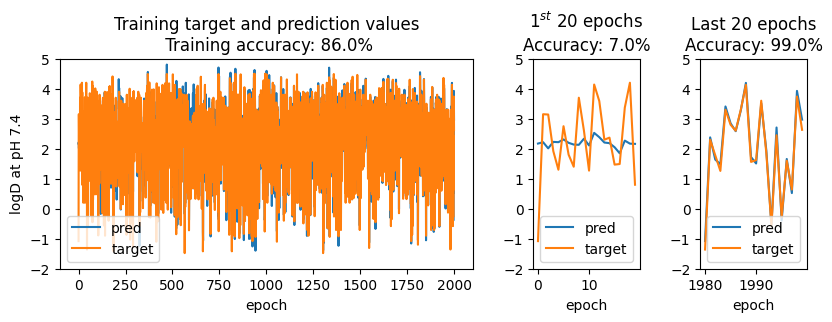

In [21]:
import matplotlib.pyplot as plt

# creating grid for subplots
fig = plt.figure(figsize=(10,6))

ax1 = plt.subplot2grid(shape=(2, 28), loc=(0,0), colspan=15)
ax2 = plt.subplot2grid(shape=(2, 28), loc=(0,17), colspan=4)
ax3 = plt.subplot2grid(shape=(2, 28), loc=(0,23), colspan=4)


results[[ 'pred', 'target']].plot(title='Training target and prediction values\n Training accuracy: ' + str(round(training_acc, 2) )+ '%',
                                  xlabel='epoch', ylabel = 'logD at pH 7.4', ax=ax1, ylim = (ymin, ymax) )
results[[ 'pred', 'target']][:20].plot(title="$1^{st}$ 20 epochs\nAccuracy: " + str(round(training_acc_1st_20, 2)) +'%',
                                       xlabel='epoch', ax=ax2, ylim = (ymin, ymax))
results[[ 'pred', 'target']][-20:].plot(title="Last 20 epochs\nAccuracy: " + str(round(training_acc_last_20, 2)) +'%',
                                       xlabel='epoch', ax=ax3, ylim = (ymin, ymax))
#fig.savefig('assets/images/pred_vs_targ.png', bbox_inches='tight')

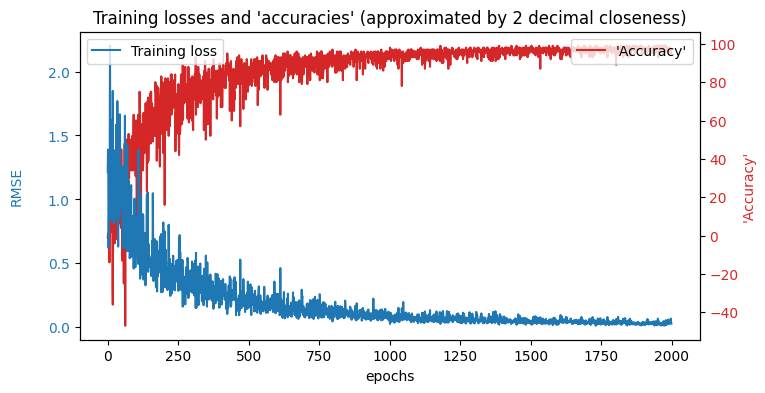

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(8,4))

color1 = 'tab:red'
ax1.set_xlabel('epochs')

ax1.tick_params(axis='y', labelcolor=color1)
sns.lineplot(data=results.accuracy, label="'Accuracy'", color=color1, ax=ax1)
plt.legend(loc='upper right')

ax2 = ax1.twinx()

color2 = 'tab:blue'
ax1.set_ylabel('RMSE' , color=color2, labelpad=40)
ax2.set_ylabel("'Accuracy'", color=color1, labelpad=30)

ax2.tick_params(axis='y', labelcolor=color2)
sns.lineplot(data=losses_float, label='Training loss', color=color2, ax=ax2)
plt.legend(loc='upper left')

ax1.yaxis.tick_right()
ax2.yaxis.tick_left()

plt.title("Training losses and 'accuracies' (approximated by 2 decimal closeness)")

plt.show()
fig.tight_layout()
#fig.savefig('assets/images/losses_and_accuracies.png', bbox_inches='tight')

In [23]:
import pandas as pd

# One batch prediction
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
    df = pd.DataFrame()
    df["y"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["real"] = df["y"].apply(lambda row: row[0])
df["pred"] = df["y_pred"].apply(lambda row: row[0])
df.head()

,y,y_pred,real,pred
0,[2.430000066757202],[1.7852295637130737],2.43,1.785230
1,[1.8300000429153442],[1.5607359409332275],1.83,1.560736
2,[1.909999966621399],[0.2713790237903595],1.91,0.271379
3,[2.1700000762939453],[1.8083460330963135],2.17,1.808346
4,[0.9800000190734863],[3.2245242595672607],0.98,3.224524


In [25]:
test_acc = r2_accuracy(df["real"], df["pred"])
test_acc_1st_20 = r2_accuracy(df["real"][:20], df["pred"][:20])

print("Test accuracy is {}%".format(round(test_acc, 2) ))
print("1st 20 test accuracy is {}%".format(round(test_acc_1st_20, 2)))

Test accuracy is 32.0%
1st 20 test accuracy is 20.0%


<Axes: title={'center': '$1^{st}$ 20 epochs\n in training.\nTrain accuracy: 7.0%\n'}, xlabel='epoch'>

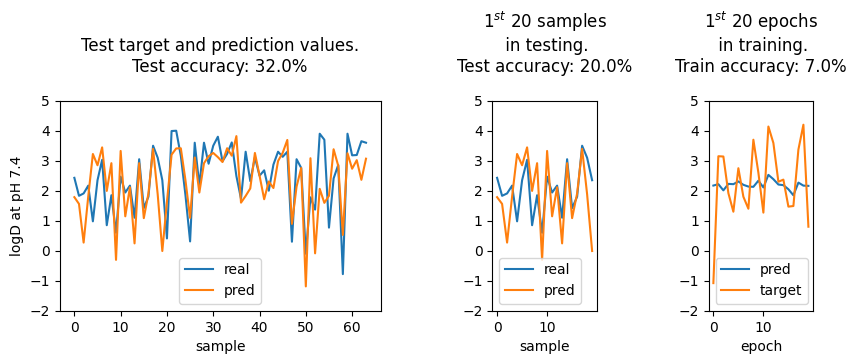

In [26]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10,6))

ax1 = plt.subplot2grid(shape=(2, 36), loc=(0,0), colspan=15)
ax2 = plt.subplot2grid(shape=(2, 36), loc=(0,20), colspan=5)
ax3 = plt.subplot2grid(shape=(2, 36), loc=(0,30), colspan=5)

test_title = "Test target and prediction values." + "\nTest accuracy: {}%\n".format(round(test_acc, 2))
df[["real", "pred"]].plot(title=test_title, xlabel='sample', ylabel = 'logD at pH 7.4',
                          ax=ax1, ylim = (ymin, ymax) )

test_title_1st_20 = "$1^{st}$ 20 samples\n in testing." + "\nTest accuracy: {}%\n".format(round(test_acc_1st_20, 2))
df[["real", "pred"]][:20].plot(title=test_title_1st_20, xlabel='sample',
                                       ax=ax2, ylim = (ymin, ymax))

train_title = "$1^{st}$ 20 epochs\n in training." + "\nTrain accuracy: {}%\n".format(round(training_acc_1st_20,2))
results[[ 'pred', 'target']][:20].plot(title=train_title,
                                       xlabel='epoch',
                                 # ylabel = 'logD at pH 7.4',
                                       ax=ax3, ylim = (ymin, ymax))
#fig.savefig('assets/images/pred_vs_targ_trained.png', bbox_inches='tight')

Full Test RMSE: 0.8668
Full Test R²:   0.4507 (45.07%)


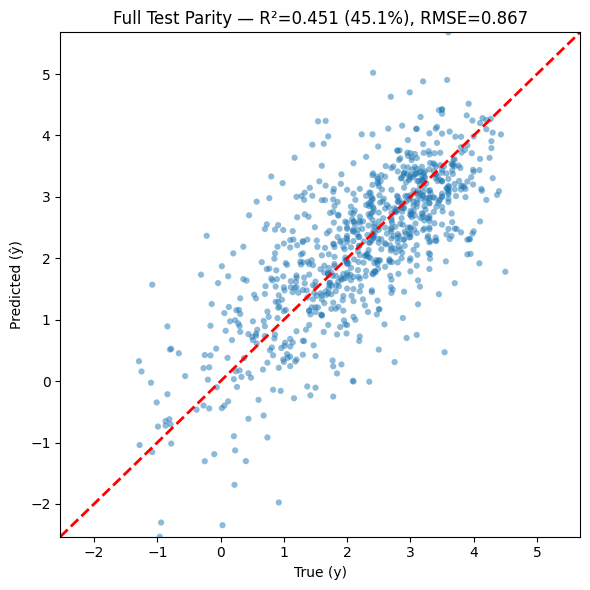

In [28]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import torch
import matplotlib.pyplot as plt

model.eval()
all_pred, all_true = [], []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred, _ = model(batch.x.float(), batch.edge_index, batch.batch)
        all_pred.append(pred.detach().cpu().view(-1))
        all_true.append(batch.y.detach().cpu().view(-1))

y_pred_full = torch.cat(all_pred).numpy()
y_true_full = torch.cat(all_true).numpy()

# Compute metrics (compat with older sklearn)
mse_full = mean_squared_error(y_true_full, y_pred_full)
rmse_full = np.sqrt(mse_full)
r2_full = r2_score(y_true_full, y_pred_full)

print(f"Full Test RMSE: {rmse_full:.4f}")
print(f"Full Test R²:   {r2_full:.4f} ({r2_full*100:.2f}%)")

# Parity plot
plt.figure(figsize=(6,6))
plt.scatter(y_true_full, y_pred_full, alpha=0.5, s=20, edgecolor="none")
lims = [min(y_true_full.min(), y_pred_full.min()),
        max(y_true_full.max(), y_pred_full.max())]
plt.plot(lims, lims, 'r--', lw=2)
plt.xlim(lims); plt.ylim(lims)
plt.xlabel("True (y)")
plt.ylabel("Predicted (ŷ)")
plt.title(f"Full Test Parity — R²={r2_full:.3f} ({r2_full*100:.1f}%), RMSE={rmse_full:.3f}")
plt.tight_layout()
plt.show()
